Some testing codes

In [ ]:
import os

def read_voxceleb_trials(trial_file):
    """Reads the VoxCeleb1 trial file."""
    pairs = []
    with open(trial_file, 'r') as f:
        for line in f:
            label, path1, path2 = line.strip().split()
            pairs.append((path1, path2, int(label)))
    return pairs

trial_file = "/path/to/voxceleb1_trials.txt"
trials = read_voxceleb_trials(trial_file)
print(f"Loaded {len(trials)} test pairs.")


In [4]:
import numpy as np
from sklearn.metrics import roc_curve

# Example: Scores from cosine similarity (replace with actual values)
genuine_scores = np.array([0.85, 0.92, 0.88, 0.91])  # Same speaker
impostor_scores = np.array([0.30, 0.45, 0.28, 0.40])  # Different speakers

# Assign labels
genuine_labels = np.ones_like(genuine_scores)  # 1 for same speaker
impostor_labels = np.zeros_like(impostor_scores)  # 0 for different speaker

# Combine scores and labels
scores = np.concatenate([genuine_scores, impostor_scores])
labels = np.concatenate([genuine_labels, impostor_labels])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)

# Compute EER where FAR ≈ FRR
fnr = 1 - tpr  # False Negative Rate
eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]
eer = fpr[np.nanargmin(np.abs(fpr - fnr))]

print(f"Equal Error Rate (EER): {eer:.4f}")
print(f"EER Threshold: {eer_threshold:.4f}")


Equal Error Rate (EER): 0.0000
EER Threshold: 0.8500


In [13]:
import os

voxceleb_path = "./wav"  # Change this to your actual dataset path
print(f"Dataset path: {voxceleb_path}")
print(f"Path exists: {os.path.exists(voxceleb_path)}")


Dataset path: ./wav
Path exists: True


Code for generating Embeddings using Pretrained Titanet

In [ ]:
import os
import pickle
import numpy as np
import torch
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from omegaconf import OmegaConf
from tqdm import tqdm

def load_titanet():
    """Load the Titanet speaker embedding model."""
    model = EncDecSpeakerLabelModel.from_pretrained(model_name="titanet_large")
    model.eval()
    return model

def extract_embedding(model, audio_path):
    """Extract speaker embedding from an audio file using the correct API."""
    with torch.no_grad():
        embedding = model.get_embedding(audio_path).cpu().numpy().flatten()
    return embedding

def process_voxceleb(voxceleb_dir, model, output_pickle, output_txt):
    """Process all audio files in the VoxCeleb directory and store embeddings."""
    embeddings = {}
    
    with open(output_txt, "w") as txt_file:
        for root, _, files in os.walk(voxceleb_dir):
            for file in tqdm(files):
                if file.endswith(".wav"):
                    file_path = os.path.join(root, file)
                    speaker_id = os.path.basename(root)  # Assuming structure: VoxCeleb/speaker_id/audio.wav
                    key = f"{speaker_id}@{file}"
                    embedding = extract_embedding(model, file_path)
                    embeddings[key] = embedding
                    
                    # Save in text format
                    txt_file.write(f"{key}: {embedding.tolist()}\n")
    
    with open(output_pickle, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Embeddings saved to {output_pickle} and {output_txt}")

if __name__ == "__main__":
    voxceleb_dir = "./wav"  # Change this to your local VoxCeleb directory
    output_pickle = "speaker_embeddings.pkl"
    output_txt = "speaker_embeddings.txt"
    
    model = load_titanet()
    process_voxceleb(voxceleb_dir, model, output_pickle, output_txt)


ModuleNotFoundError: No module named 'nemo'

Codef or generating Speaker embeddings using fine tuned model present in your local directory

In [ ]:
import os
import pickle
import numpy as np
import torch
from nemo.collections.asr.models import EncDecSpeakerLabelModel
from omegaconf import OmegaConf
from tqdm import tqdm

def load_titanet():
    """Load the Titanet speaker embedding model."""
    #model = EncDecSpeakerLabelModel.restore_from("titanet-mera.nemo")
    model = EncDecSpeakerLabelModel.restore_from("./titanet-large-IMSV.nemo")
    model.eval()
    return model

def extract_embedding(model, audio_path):
    """Extract speaker embedding from an audio file using the correct API."""
    with torch.no_grad():
        embedding = model.get_embedding(audio_path).cpu().numpy().flatten()
    return embedding

def process_voxceleb(voxceleb_dir, model, output_pickle, output_txt):
    """Process all audio files in the VoxCeleb directory and store embeddings."""
    embeddings = {}
    
    with open(output_txt, "w") as txt_file:
        for root, dirs, files in os.walk(voxceleb_dir):
            if files:  # Only process if there are audio files
                speaker_id = os.path.basename(os.path.dirname(root))  # Get the speaker ID from the parent directory
                for file in tqdm(files):
                    if file.endswith(".wav"):
                        file_path = os.path.join(root, file)
                        key = f"{speaker_id}@{file}"
                        embedding = extract_embedding(model, file_path)
                        embeddings[key] = embedding
                        
                        # Save in text format
                        txt_file.write(f"{key}: {embedding.tolist()}\n")
    
    with open(output_pickle, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Embeddings saved to {output_pickle} and {output_txt}")

if __name__ == "__main__":
    voxceleb_dir = "./segregated/English"  # Change this to your local VoxCeleb directory
    output_pickle = "speaker_embeddings-IMSV_English.pkl"
    output_txt = "speaker_embeddings-mera-IMSV_English.txt"
    
    model = load_titanet()
    process_voxceleb(voxceleb_dir, model, output_pickle, output_txt)


In [ ]:
import os
import re

def verify_files(text_file, root_directory):
    with open(text_file, 'r') as f:
        missing_files = []
        for line in f:
            line = line.strip()
            match = re.match(r"(\w+)@([\w.]+)", line)
            if match:
                folder, filename = match.groups()
                folder_path = os.path.join(root_directory, folder)
                file_path = os.path.join(folder_path, filename)
                if not os.path.exists(file_path):
                    missing_files.append(file_path)
    
    if missing_files:
        print("The following files are missing:")
        for file in missing_files:
            print(file)
    else:
        print("All files are present.")

# Example usage
text_file = "./speaker_embeddings.txt"  # Text file containing the filenames
root_directory = "./wav"  # Update this to your actual root folder
verify_files(text_file, root_directory)

In [7]:
import re

def remove_middle_folder(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            parts = line.strip().split()
            processed_parts = [parts[0]] + [re.sub(r'/[^/]+/', '/', path) for path in parts[1:]]
            outfile.write(" ".join(processed_parts) + "\n")

# Example usage:
input_file = "./vox-test.txt"  # Replace with your input filename
output_file = "./vox_test2.txt"  # Replace with your output filename
remove_middle_folder(input_file, output_file)


Code to segregate all language files 

In [18]:
import os
import shutil

def segregate_audio_files(audio_dir):
    """
    Segregates audio files in the given directory into subfolders based on the
    language code in their filenames, following the IITG-MV database naming convention.

    Args:
        audio_dir (str): The path to the directory containing the audio files.
    """

    language_codes = {
        "AS": "Assamese",
        "BN": "Bengali",
        "BD": "Bodo",
        "DG": "Dogri",
        "EN": "English",
        "GJ": "Gujarati",
        "HN": "Hindi",
        "KN": "Kannada",
        "KS": "Kashmiri",
        "KK": "Konkani",
        "MT": "Maithili",
        "MN": "Manipuri",
        "MR": "Marathi",
        "NP": "Nepali",
        "OR": "Oriya",
        "PN": "Punjabi",
        "SN": "Sanskrit",
        "ST": "Santali",
        "SD": "Sindhi",
        "TM": "Tamil",
        "TL": "Telugu",
        "UR": "Urdu",
        "ML": "Malayalam",
        "MZ": "Mizo"
    }

    for filename in os.listdir(audio_dir):
        if filename.endswith(".wav") or filename.endswith(".mp3") or filename.endswith(".amr"):
            parts = filename.split("_")
            if len(parts) > 1:
                recording_conditions = parts[1].split(".")[0]
                if len(recording_conditions) >= 6:
                    language_code = recording_conditions[-3:-1]
                    if language_code in language_codes:
                        language_name = language_codes[language_code]
                        language_folder = os.path.join(audio_dir, language_name)
                        os.makedirs(language_folder, exist_ok=True)
                        source_path = os.path.join(audio_dir, filename)
                        destination_path = os.path.join(language_folder, filename)
                        shutil.move(source_path, destination_path)
                        print(f"Moved '{filename}' to '{language_name}' folder.")
                    else:
                        print(f"Could not identify language for '{filename}'. Extracted code: '{language_code}'")
                else:
                    print(f"Filename '{filename}' does not follow the expected format: '{filename}'")
            else:
                print(f"Filename '{filename}' does not follow the expected format: '{filename}'")

if __name__ == "__main__":
    audio_directory = input("Enter the directory containing the audio files: ")
    segregate_audio_files(audio_directory)
    print("Audio file segregation complete.")

Moved '1043_BD01OENC.wav' to 'English' folder.
Moved '1043_BD01OHNC.wav' to 'Hindi' folder.
Moved '1043_BH01OENC.wav' to 'English' folder.
Moved '1043_BH01OHNC.wav' to 'Hindi' folder.
Moved '1043_BM01OENC.wav' to 'English' folder.
Moved '1043_BM01OHNC.wav' to 'Hindi' folder.
Moved '1043_BM02OENC.wav' to 'English' folder.
Moved '1043_BM02OHNC.wav' to 'Hindi' folder.
Moved '1043_BT01OENC.wav' to 'English' folder.
Moved '1043_BT01OHNC.wav' to 'Hindi' folder.
Moved '1066_BD01OENC.wav' to 'English' folder.
Moved '1066_BD01OHNC.wav' to 'Hindi' folder.
Moved '1066_BH01OENC.wav' to 'English' folder.
Moved '1066_BH01OHNC.wav' to 'Hindi' folder.
Moved '1066_BM01OENC.wav' to 'English' folder.
Moved '1066_BM01OHNC.wav' to 'Hindi' folder.
Moved '1066_BM02OENC.wav' to 'English' folder.
Moved '1066_BM02OHNC.wav' to 'Hindi' folder.
Moved '1066_BT01OENC.wav' to 'English' folder.
Moved '1066_BT01OHNC.wav' to 'Hindi' folder.
Moved '1067_BD01OENC.wav' to 'English' folder.
Moved '1067_BD01OORC.wav' to 'Ori

Code to generate labels comparing one folder

In [4]:
import os

def collect_audio_files(audio_dir):
    """
    Recursively collect audio filenames and their speaker IDs
    based on the immediate subfolder under `audio_dir`.
    """
    audio_data = []

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.amr')):
                speaker_id = os.path.relpath(root, audio_dir).split(os.sep)[0]
                key = f"{speaker_id}@{file}"
                audio_data.append((speaker_id, key))

    return audio_data

def compare_speaker_ids(audio_dir, output_filename):
    """
    Compares speaker IDs based on folder names and writes pairwise labels.

    Args:
        audio_dir (str): Path to audio directory structured by speaker IDs.
        output_filename (str): Output file to write labels and file pairs.
    """
    audio_data = collect_audio_files(audio_dir)

    with open(output_filename, 'w') as outfile:
        for i in range(len(audio_data)):
            speaker_id1, key1 = audio_data[i]
            for j in range(len(audio_data)):
                speaker_id2, key2 = audio_data[j]

                label = 1 if speaker_id1 == speaker_id2 else 0
                outfile.write(f"{label} {key1} {key2}\n")

    print(f"Speaker ID comparison complete. Results saved to '{output_filename}'")

if __name__ == "__main__":
    audio_directory = input("Enter the directory containing the audio files: ")
    output_file = input("Enter the name for the output text file (e.g., comparison.txt): ")
    compare_speaker_ids(audio_directory, output_file)


Speaker ID comparison complete. Results saved to 'labels.txt'


creating chunks of only 8 secs of the audio files without changing the speaker ID taking the reference of Voxceleb Dataset

In [ ]:
import os
import wave
import contextlib
from pydub import AudioSegment

def split_wav_files(base_dir):
    chunk_base_dir = os.path.join(base_dir, "chunk")
    os.makedirs(chunk_base_dir, exist_ok=True)
    
    # Iterate through all label directories in the base directory
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if not os.path.isdir(label_path) or label == "chunk":
            continue
        
        label_chunk_dir = os.path.join(chunk_base_dir, label)
        os.makedirs(label_chunk_dir, exist_ok=True)
        
        for filename in os.listdir(label_path):
            if filename.endswith(".wav"):
                file_path = os.path.join(label_path, filename)
                audio = AudioSegment.from_wav(file_path)
                duration_ms = len(audio)
                chunk_size = 8000  # 8 seconds in milliseconds
                
                # Split and save chunks
                for i, start in enumerate(range(0, duration_ms, chunk_size)):
                    end = min(start + chunk_size, duration_ms)
                    chunk = audio[start:end]
                    chunk_filename = f"{os.path.splitext(filename)[0]}_chunk{i+1}.wav"
                    chunk.export(os.path.join(label_chunk_dir, chunk_filename), format="wav")

if __name__ == "__main__":
    base_directory = "./TEST"  # Adjust if necessary
    split_wav_files(base_directory)
    print("creating chunks completed")



Segregate Speakers according to Speaker ID

In [24]:
import os
import shutil

def get_speaker_id(filename):
    """Extract speaker ID (first 4 characters before underscore)."""
    return filename.split('_')[0]

def segregate_audio_by_speaker(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for filename in os.listdir(source_dir):
        if filename.endswith('.wav'):
            speaker_id = get_speaker_id(filename)
            speaker_folder = os.path.join(destination_dir, speaker_id)

            if not os.path.exists(speaker_folder):
                os.makedirs(speaker_folder)

            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(speaker_folder, filename)

            shutil.move(src_path, dst_path)

    print("[✓] Files segregated by speaker ID successfully.")

# Example usage
segregate_audio_by_speaker("./segregated/Other languages", "segregated_audio")


[✓] Files segregated by speaker ID successfully.


Folder to Foldder camparision for english to Fav and fav to english

In [9]:
import os

def get_speaker_id(filename):
    """Extracts the speaker ID (first 4 characters before underscore) from filename."""
    return filename.split('_')[0]

def get_all_wav_files(root_folder):
    """Returns list of (speaker_id, full_path, relative_path) tuples for all .wav files in subdirectories."""
    wav_files = []
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            if file.endswith('.wav'):
                full_path = os.path.join(subdir, file)
                rel_path = os.path.relpath(full_path)
                speaker_id = get_speaker_id(file)
                wav_files.append((speaker_id, file, rel_path))
    return wav_files

def generate_labels(folder1, folder2, output_file='labels.txt'):
    files1 = get_all_wav_files(folder1)
    files2 = get_all_wav_files(folder2)

    with open(output_file, 'w') as out:
        for spk1, file1, path1 in files1:
            for spk2, file2, path2 in files2:
                label = 1 if spk1 == spk2 else 0
                out.write(f"{label} {spk1}@{file1} {spk2}@{file2}\n")
                # Alternatively, use full paths:
                # out.write(f"{label} {path1} {path2}\n")

    print(f"[✓] Labels saved to {output_file}")

# Example usage
generate_labels('./english', './favourites', 'English_To_Favourites_VOIP.txt')


[✓] Labels saved to English_To_Favourites_VOIP.txt


Segregating chunked files 

In [2]:
import os
import shutil

source_folder = './TEST'
english_folder = 'english'
favourite_language_folder = 'favourite_language'

# Create main destination folders if they don't exist
os.makedirs(english_folder, exist_ok=True)
os.makedirs(favourite_language_folder, exist_ok=True)

for speaker_id in os.listdir(source_folder):
    speaker_path = os.path.join(source_folder, speaker_id)
    print(f"Processing speaker folder: {speaker_path}")
    if os.path.isdir(speaker_path):
        # Create speaker ID subfolders in destination folders
        english_speaker_folder = os.path.join(english_folder, speaker_id)
        favourite_language_speaker_folder = os.path.join(favourite_language_folder, speaker_id)
        os.makedirs(english_speaker_folder, exist_ok=True)
        os.makedirs(favourite_language_speaker_folder, exist_ok=True)
        print(f"Created English speaker folder: {english_speaker_folder}")
        print(f"Created Favourite Language speaker folder: {favourite_language_speaker_folder}")

        for filename in os.listdir(speaker_path):
            if filename.endswith('.wav'):
                name_without_extension = filename[:-4]  # Remove .wav extension
                parts = name_without_extension.split('_')
                if len(parts) > 1:
                    code_part = parts[1]
                    if len(code_part) >= 2:
                        language_code = code_part[5:7]  # Extract last two characters as language code
                        source_file = os.path.join(speaker_path, filename)
                        print(f"Processing file: {source_file}, Language Code: {language_code}")

                        if language_code == 'EN':
                            destination_path = os.path.join(english_speaker_folder, filename)
                            shutil.copy(source_file, destination_path)
                            print(f"Copied to: {destination_path}")
                        else:
                            destination_path = os.path.join(favourite_language_speaker_folder, filename)
                            shutil.copy(source_file, destination_path)
                            print(f"Copied to: {destination_path}")
                    else:
                        print(f"Skipping file due to short code part in filename: {filename}")
                else:
                    print(f"Skipping file due to incorrect filename format: {filename}")
            else:
                print(f"Skipping non-WAV file: {filename}")
    else:
        print(f"Skipping non-directory item: {speaker_id}")

print("File segregation process completed (files copied).")

Processing speaker folder: ./TEST\1043
Created English speaker folder: english\1043
Created Favourite Language speaker folder: favourite_language\1043
Processing file: ./TEST\1043\1043_BD01OENC.wav, Language Code: EN
Copied to: english\1043\1043_BD01OENC.wav
Processing file: ./TEST\1043\1043_BD01OHNC.wav, Language Code: HN
Copied to: favourite_language\1043\1043_BD01OHNC.wav
Processing file: ./TEST\1043\1043_BH01OENC.wav, Language Code: EN
Copied to: english\1043\1043_BH01OENC.wav
Processing file: ./TEST\1043\1043_BH01OHNC.wav, Language Code: HN
Copied to: favourite_language\1043\1043_BH01OHNC.wav
Processing file: ./TEST\1043\1043_BM01OENC.wav, Language Code: EN
Copied to: english\1043\1043_BM01OENC.wav
Processing file: ./TEST\1043\1043_BM01OHNC.wav, Language Code: HN
Copied to: favourite_language\1043\1043_BM01OHNC.wav
Processing file: ./TEST\1043\1043_BM02OENC.wav, Language Code: EN
Copied to: english\1043\1043_BM02OENC.wav
Processing file: ./TEST\1043\1043_BM02OHNC.wav, Language Cod

In [9]:
import os

def get_speaker_id(filename):
    """Extracts the speaker ID (first 4 digits before underscore) from filename."""
    parts = filename.split('_')
    if len(parts) < 2:
        print(f"[!] Filename format invalid: {filename}")
        return None
    return parts[0]

def generate_labels(folder1, folder2, output_file='labels.txt'):
    if not os.path.isdir(folder1) or not os.path.isdir(folder2):
        print("[✗] One or both folders do not exist.")
        return

    files1 = sorted([f for f in os.listdir(folder1) if f.endswith('.wav')])
    files2 = sorted([f for f in os.listdir(folder2) if f.endswith('.wav')])

    print(f"[i] Found {len(files1)} files in {folder1}")
    print(f"[i] Found {len(files2)} files in {folder2}")

    if not files1 or not files2:
        print("[✗] No .wav files to process.")
        return

    count = 0
    with open(output_file, 'w') as out:
        for file1 in files1:
            speaker1 = get_speaker_id(file1)
            if not speaker1:
                continue
            for file2 in files2:
                speaker2 = get_speaker_id(file2)
                if not speaker2:
                    continue
                label = 1 if speaker1 == speaker2 else 0
                out.write(f"{label} {os.path.join(folder1, file1)} {os.path.join(folder2, file2)}\n")
                count += 1

    print(f"[✓] Labels saved to {output_file} — {count} pairs written.")

# Example usage
generate_labels('./english', './favourite_language', 'english_to_other.txt')


[i] Found 0 files in ./english
[i] Found 0 files in ./favourite_language
[✗] No .wav files to process.


In [ ]:
import os

def collect_audio_files(audio_dir):
    """
    Recursively collect audio filenames and their speaker IDs
    based on the immediate subfolder under `audio_dir`.
    """
    audio_data = []

    for root, dirs, files in os.walk(audio_dir):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.amr')):
                speaker_id = os.path.relpath(root, audio_dir).split(os.sep)[0]
                key = f"{speaker_id}@{file}"
                audio_data.append((speaker_id, key))

    return audio_data

def compare_speaker_ids_between_dirs(audio_dir1, audio_dir2, output_filename):
    """
    Compares speaker IDs between two directories and writes pairwise labels.

    Args:
        audio_dir1 (str): Path to the first audio directory.
        audio_dir2 (str): Path to the second audio directory.
        output_filename (str): Output file to write labels and file pairs.
    """
    audio_data1 = collect_audio_files(audio_dir1)
    audio_data2 = collect_audio_files(audio_dir2)

    with open(output_filename, 'w') as outfile:
        for speaker_id1, key1 in audio_data1:
            for speaker_id2, key2 in audio_data2:
                label = 1 if speaker_id1 == speaker_id2 else 0
                outfile.write(f"{label} {key1} {key2}\n")

    print(f"Speaker ID comparison between folders complete. Results saved to '{output_filename}'")

if __name__ == "__main__":
    audio_directory1 = input("Enter the FIRST directory containing audio files: ")
    audio_directory2 = input("Enter the SECOND directory containing audio files: ")
    output_file = input("Enter the name for the output text file (e.g., comparison.txt): ")

    compare_speaker_ids_between_dirs(audio_directory1, audio_directory2, output_file)


Speaker ID comparison between folders complete. Results saved to 'others_to_english.txt'


: 

t-sne plot test

TypeError: annotate() missing 1 required positional argument: 'xy'

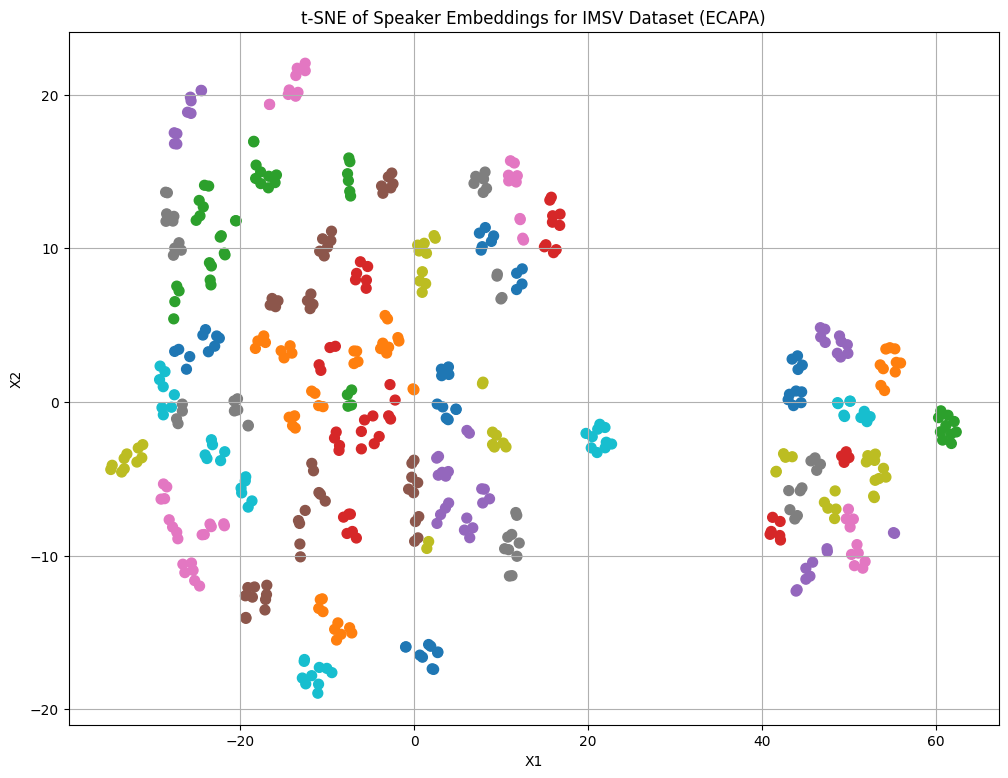

In [14]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 🔧 Step 1: Set your pkl path here
pkl_path = './speaker_embeddings_ECAPA.pkl'  # e.g., 'C:/Users/Lokesh/Desktop/embeddings.pkl'

# Step 2: Load the dictionary from pkl
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)  # data is a dict: {filename: embedding_vector}

# Step 3: Extract embeddings and labels
keys = list(data.keys())
embeddings = np.array([data[k] for k in keys])

# Optional: Generate simple numeric labels (like 0, 1, 2...) for plotting
labels = np.arange(len(keys))

# Step 4: Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# Step 5: Plot
plt.figure(figsize=(12, 9))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab10', s=50)
plt.title('t-SNE of Speaker Embeddings for IMSV Dataset (ECAPA)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)

# Optionally annotate a few points (not all to avoid clutter)
for i in range(0, len(keys), max(1, len(keys) // 20)):
    plt.annotate((tsne_result[i, 0], tsne_result[i, 1]))

# Step 6: Save the plot
save_path = os.path.join(os.path.dirname(pkl_path), 'tsne_plot.png')
plt.savefig(save_path)
plt.show()

print(f"✅ t-SNE plot saved at: {save_path}")


TypeError: annotate() missing 1 required positional argument: 'xy'

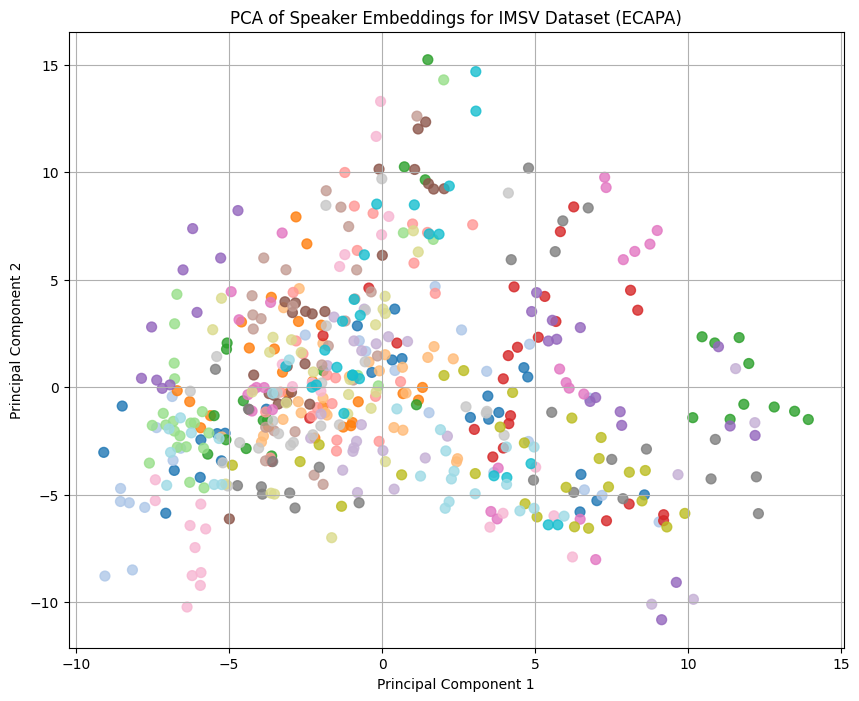

In [13]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 🔧 Set your .pkl file path here
pkl_path = './speaker_embeddings_ECAPA.pkl'  # Example: 'C:/Users/Lokesh/Desktop/embeddings.pkl'

# 📦 Load the speaker embeddings
with open(pkl_path, 'rb') as f:
    data = pickle.load(f)  # Expected format: { "speaker_id@file.wav": [embedding_vector] }

# 🎯 Extract data
keys = list(data.keys())
embeddings = np.array([data[k] for k in keys])

# 🎨 Assign numerical labels (if needed for coloring)
labels = np.arange(len(keys))

# 📐 Optional: Standardize before PCA (optional, but often helps)
scaler = StandardScaler()
embeddings_std = scaler.fit_transform(embeddings)

# 🧠 Apply PCA (2 components for 2D plotting)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_std)

# 📊 Plot PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab20', s=50, alpha=0.8)
plt.title('PCA of Speaker Embeddings for IMSV Dataset (ECAPA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

# Optional: annotate a few points with speaker IDs
for i in range(0, len(keys), max(1, len(keys)//30)):
    speaker_id = keys[i].split('@')[0]
    plt.annotate((pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.7)

# 💾 Save plot in the same folder as .pkl
save_path = os.path.join(os.path.dirname(pkl_path), 'pca_plot.png')
plt.savefig(save_path)
plt.show()

print(f"✅ PCA plot saved at: {save_path}")


Seperate files on the basis of sensors

In [4]:
import os
import shutil

sensor_map = {
    'H01': 'Headset_Microphone',
    'T01': 'Tablet_PC',
    'D01': 'Digital_Voice_Recorder',
    'M01': 'Mobile_Nokia_Offline',
    'M02': 'Mobile_SonyEricsson_Offline',
    'M03': 'Mobile_Nokia_Online',
    'M04': 'Mobile_Offline_Handsfree'
}

def sort_nested_wav_files_with_speaker_folders(test_root_dir):
    sorted_dir = os.path.join(os.path.dirname(test_root_dir), 'sorted')
    os.makedirs(sorted_dir, exist_ok=True)

    speaker_folders = [f for f in os.listdir(test_root_dir) if os.path.isdir(os.path.join(test_root_dir, f))]
    print(f"Found {len(speaker_folders)} speaker folders inside '{test_root_dir}'")

    for speaker_id in speaker_folders:
        speaker_path = os.path.join(test_root_dir, speaker_id)
        wav_files = os.listdir(speaker_path)

        for filename in wav_files:
            if filename.lower().endswith(".wav"):
                parts = filename.split('_')
                if len(parts) >= 2 and len(parts[1]) >= 4:
                    sensor_id = parts[1][1:4]  # ✅ Correct extraction of 3-letter sensor ID
                    sensor_name = sensor_map.get(sensor_id, 'Unknown_Sensor')

                    dest_dir = os.path.join(sorted_dir, sensor_name, speaker_id)
                    os.makedirs(dest_dir, exist_ok=True)

                    src_path = os.path.join(speaker_path, filename)
                    dest_path = os.path.join(dest_dir, filename)

                    shutil.copy2(src_path, dest_path)
                    print(f"Copied {filename} → {dest_dir}")
                else:
                    print(f"Skipped: {filename} — invalid naming pattern")
            else:
                print(f"Skipped: {filename} — not a .wav file")

# 👇 Paste your path here
your_test_folder = r"C:\Lokesh\speaker-verification\evaluation_speaker_verification\TEST"
sort_nested_wav_files_with_speaker_folders(your_test_folder)


Found 50 speaker folders inside 'C:\Lokesh\speaker-verification\evaluation_speaker_verification\TEST'
Copied 1043_BD01OENC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Digital_Voice_Recorder\1043
Copied 1043_BD01OHNC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Digital_Voice_Recorder\1043
Copied 1043_BH01OENC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Headset_Microphone\1043
Copied 1043_BH01OHNC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Headset_Microphone\1043
Copied 1043_BM01OENC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Mobile_Nokia_Offline\1043
Copied 1043_BM01OHNC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Mobile_Nokia_Offline\1043
Copied 1043_BM02OENC.wav → C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted\Mobile_SonyEricsson_Offline\1043
Copied 1043_BM02OHNC.wav → C:\

Generate Trail files for different sensors

In [5]:
import os
from collections import defaultdict

def generate_sensorwise_verification_pairs(sorted_root, output_folder='comparison_files', max_impostors=5):
    os.makedirs(output_folder, exist_ok=True)

    # Structure: sensor -> speaker_id -> list of files
    sensor_data = defaultdict(lambda: defaultdict(list))

    # STEP 1: Collect data from folder structure
    for sensor in os.listdir(sorted_root):
        sensor_path = os.path.join(sorted_root, sensor)
        if not os.path.isdir(sensor_path):
            continue
        for speaker_id in os.listdir(sensor_path):
            speaker_path = os.path.join(sensor_path, speaker_id)
            for fname in os.listdir(speaker_path):
                if fname.endswith(".wav"):
                    identifier = f"{speaker_id}@{fname}"
                    sensor_data[sensor][speaker_id].append(identifier)

    # STEP 2: Generate 25 comparison files
    for train_sensor in sensor_data:
        for test_sensor in sensor_data:
            filename = f"{train_sensor}_to_{test_sensor}.txt".replace(" ", "_")
            output_path = os.path.join(output_folder, filename)

            with open(output_path, 'w') as out:
                for speaker_id in sensor_data[train_sensor]:
                    train_files = sensor_data[train_sensor][speaker_id]
                    test_files = sensor_data[test_sensor].get(speaker_id, [])

                    # Genuine comparisons (same speaker, label = 1)
                    for f1 in train_files:
                        for f2 in test_files:
                            if f1 != f2:
                                out.write(f"1 {f1} {f2}\n")

                        # Impostor comparisons (different speakers, label = 0)
                        impostor_count = 0
                        for other_speaker in sensor_data[test_sensor]:
                            if other_speaker != speaker_id:
                                for imp_file in sensor_data[test_sensor][other_speaker]:
                                    out.write(f"0 {f1} {imp_file}\n")
                                    impostor_count += 1
                                    if impostor_count >= max_impostors:
                                        break
                            if impostor_count >= max_impostors:
                                break

            print(f"[✓] Created: {filename}")

# --- JUST CALL THIS FUNCTION WITH YOUR FOLDER PATH ---
# Example:
generate_sensorwise_verification_pairs(
    sorted_root=r"C:\Lokesh\speaker-verification\evaluation_speaker_verification\sorted"
)


[✓] Created: Digital_Voice_Recorder_to_Digital_Voice_Recorder.txt
[✓] Created: Digital_Voice_Recorder_to_Headset_Microphone.txt
[✓] Created: Digital_Voice_Recorder_to_Mobile_Nokia_Offline.txt
[✓] Created: Digital_Voice_Recorder_to_Mobile_SonyEricsson_Offline.txt
[✓] Created: Digital_Voice_Recorder_to_Tablet_PC.txt
[✓] Created: Headset_Microphone_to_Digital_Voice_Recorder.txt
[✓] Created: Headset_Microphone_to_Headset_Microphone.txt
[✓] Created: Headset_Microphone_to_Mobile_Nokia_Offline.txt
[✓] Created: Headset_Microphone_to_Mobile_SonyEricsson_Offline.txt
[✓] Created: Headset_Microphone_to_Tablet_PC.txt
[✓] Created: Mobile_Nokia_Offline_to_Digital_Voice_Recorder.txt
[✓] Created: Mobile_Nokia_Offline_to_Headset_Microphone.txt
[✓] Created: Mobile_Nokia_Offline_to_Mobile_Nokia_Offline.txt
[✓] Created: Mobile_Nokia_Offline_to_Mobile_SonyEricsson_Offline.txt
[✓] Created: Mobile_Nokia_Offline_to_Tablet_PC.txt
[✓] Created: Mobile_SonyEricsson_Offline_to_Digital_Voice_Recorder.txt
[✓] Created

Comparing t-SNE Plots

C:\Users\hp\AppData\Local\Temp\ipykernel_5928\3323806188.py:58: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Temp\ipykernel_5928\3323806188.py:58: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\hp\AppData\Local\Temp\ipykernel_5928\3323806188.py:59: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  plt.savefig(save_path)
C:\Users\hp\AppData\Local\Temp\ipykernel_5928\3323806188.py:59: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.savefig(save_path)
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\hp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128994 (\N{LARGE GREEN

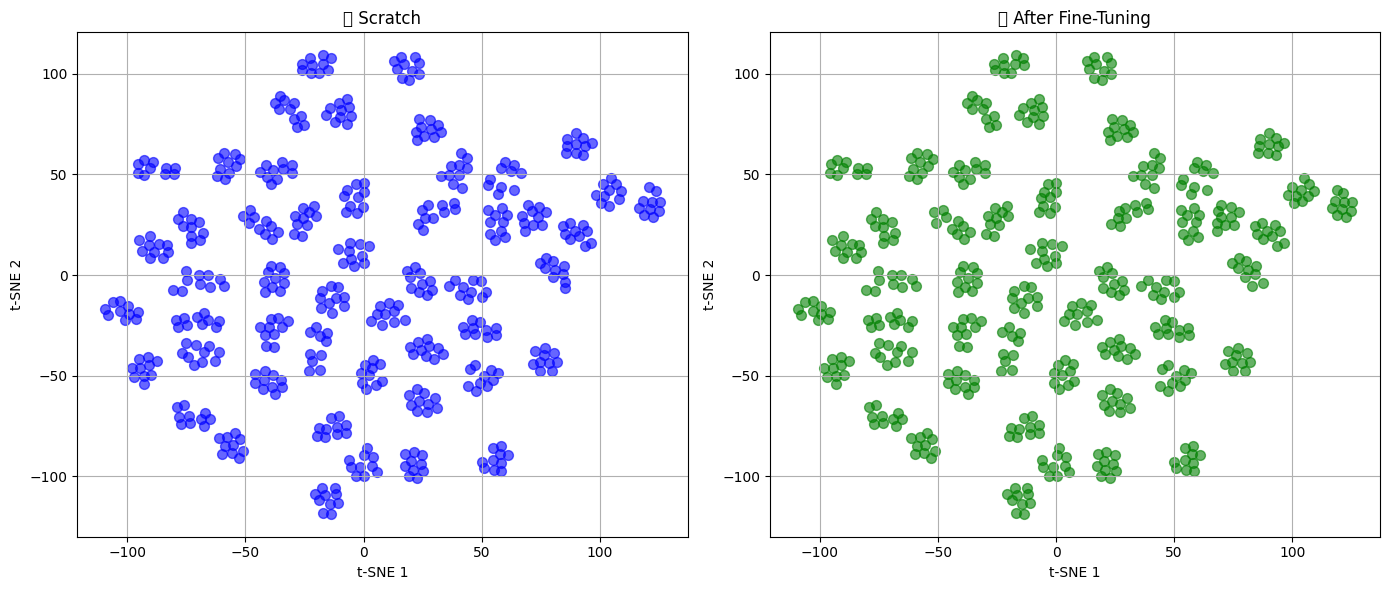

✅ Comparison t-SNE plot saved at: C:\Lokesh\speaker-verification\evaluation_speaker_verification\tsne_comparison.png


In [20]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Set paths to both pkl files
before_path = r'C:\Lokesh\speaker-verification\evaluation_speaker_verification\speaker_embeddings_scratch.pkl'
after_path = r'C:\Lokesh\speaker-verification\evaluation_speaker_verification\speaker_embeddings_finetuned.pkl'

# Load the embeddings
with open(before_path, 'rb') as f:
    data_before = pickle.load(f)

with open(after_path, 'rb') as f:
    data_after = pickle.load(f)

# Make sure both have the same set of keys (optional sanity check)
common_keys = list(set(data_before.keys()) & set(data_after.keys()))
common_keys.sort()

# Extract embeddings
embeddings_before = np.array([data_before[k] for k in common_keys])
embeddings_after = np.array([data_after[k] for k in common_keys])

# Stack all embeddings together for joint t-SNE
combined_embeddings = np.vstack([embeddings_before, embeddings_after])

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(combined_embeddings)

# Split the results
tsne_before = tsne_result[:len(common_keys)]
tsne_after = tsne_result[len(common_keys):]

# Plotting
plt.figure(figsize=(14, 6))

# Before fine-tuning
plt.subplot(1, 2, 1)
plt.scatter(tsne_before[:, 0], tsne_before[:, 1], c='blue', s=50, alpha=0.6)
plt.title('🔵 Scratch')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)

# After fine-tuning
plt.subplot(1, 2, 2)
plt.scatter(tsne_after[:, 0], tsne_after[:, 1], c='green', s=50, alpha=0.6)
plt.title('🟢 After Fine-Tuning')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True)

# Save plot
save_path = os.path.join(os.path.dirname(before_path), 'tsne_comparison.png')
plt.tight_layout()
plt.savefig(save_path)
plt.show()

print(f"✅ Comparison t-SNE plot saved at: {save_path}")


Evaluating speaker_embeddings_scratch.pkl: 250000it [00:04, 58784.26it/s]


Model: Scratch Model, #Scores: 250000, #Labels: 250000


Evaluating speaker_embeddings_pretrained.pkl: 250000it [00:03, 70319.85it/s]


Model: Pretrained Model, #Scores: 250000, #Labels: 250000


Evaluating speaker_embeddings_finetuned.pkl: 250000it [00:03, 80920.67it/s]


Model: Finetuned Model, #Scores: 250000, #Labels: 250000


Evaluating speaker_embeddings.pkl: 250000it [00:03, 82663.19it/s]


Model: Ecapa-TDNN, #Scores: 250000, #Labels: 250000


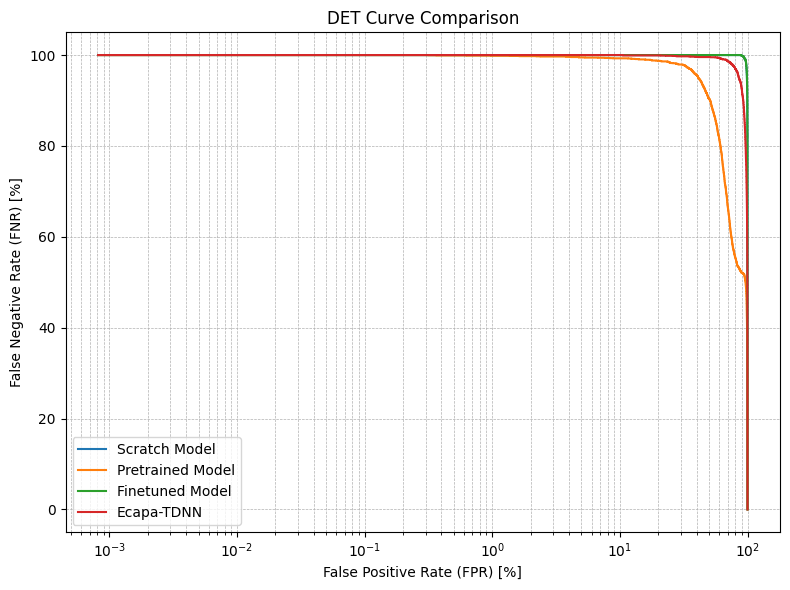

: 

In [ ]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import det_curve
from tqdm import tqdm

def process_trial_file(trial_file, emb_path):
    with open(emb_path, 'rb') as f:
        emb = pkl.load(f)

    scores, labels = [], []

    with open(trial_file, 'r') as f:
        for line in tqdm(f, desc=f"Evaluating {os.path.basename(emb_path)}"):
            label, x_spk, y_spk = line.strip().split()
            x_spk = '@'.join(x_spk.split('/'))
            y_spk = '@'.join(y_spk.split('/'))

            x_emb = emb[x_spk]
            y_emb = emb[y_spk]

            cos_sim = np.dot(x_emb, y_emb) / (np.linalg.norm(x_emb) * np.linalg.norm(y_emb))
            score = (cos_sim + 1) / 2
            scores.append(1 - score)  # distance for DET
            labels.append(int(label))

    return np.array(labels), np.array(scores)

# === Config ===
embedding_files = [
    "./speaker_embeddings_scratch.pkl",
    "./speaker_embeddings_pretrained.pkl",
    "./speaker_embeddings_finetuned.pkl",
    "./speaker_embeddings.pkl"
]
model_names = [
    "Scratch Model",
    "Pretrained Model",
    "Finetuned Model",
    "Ecapa-TDNN"

]
trial_file = "./Labels.txt"

# === Plotting DET ===
plt.figure(figsize=(8, 6))

for emb_path, name in zip(embedding_files, model_names):
    y_true, y_scores = process_trial_file(trial_file, emb_path)
    fpr, fnr, _ = det_curve(y_true, y_scores)
    print(f"Model: {name}, #Scores: {len(y_scores)}, #Labels: {len(y_true)}")
    plt.semilogx(fpr * 100, fnr * 100, label=name)  # log scale X axis

plt.xlabel('False Positive Rate (FPR) [%]')
plt.ylabel('False Negative Rate (FNR) [%]')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
#plt.xlim([0.1, 40])
#plt.ylim([0.1, 45])
plt.title('DET Curve Comparison')
plt.tight_layout()
plt.savefig("det_curve.png", dpi=300)
plt.show()


Seperating English and Favourite language folders for VOIP Dataset

In [3]:
import os
import shutil

def copy_files_by_language(root_dir, english_dir='english', favourites_dir='favourites'):
    audio_extensions = ('.wav', '.mp3', '.amr')

    # Ensure destination root folders exist
    os.makedirs(english_dir, exist_ok=True)
    os.makedirs(favourites_dir, exist_ok=True)

    for speaker_id in os.listdir(root_dir):
        speaker_path = os.path.join(root_dir, speaker_id)

        if not os.path.isdir(speaker_path):
            continue

        for lang_folder in os.listdir(speaker_path):
            lang_path = os.path.join(speaker_path, lang_folder)

            if not os.path.isdir(lang_path):
                continue

            # Select destination based on folder name
            if lang_folder.upper() == 'EN':
                dest_path = os.path.join(english_dir, speaker_id)
            else:
                dest_path = os.path.join(favourites_dir, speaker_id)

            os.makedirs(dest_path, exist_ok=True)

            for file in os.listdir(lang_path):
                if file.endswith(audio_extensions):
                    src_file = os.path.join(lang_path, file)
                    dest_file = os.path.join(dest_path, file)
                    shutil.copy2(src_file, dest_file)

    print(f"Files copied successfully to '{english_dir}' and '{favourites_dir}'.")

if __name__ == "__main__":
    root_audio_dir = input("Enter the path to 'VOIP TEST' directory: ")
    copy_files_by_language(root_audio_dir)


Files copied successfully to 'english' and 'favourites'.


Generating labels for VOIP English to Fav and Fav to English

In [13]:
import os

def get_all_wav_files(root_folder):
    """Returns list of (speaker_id, full_path, relative_path) tuples for all .wav files in subdirectories."""
    wav_files = []
    for subdir, _, files in os.walk(root_folder):
        speaker_id = os.path.basename(subdir)  # Extract speaker ID from folder name
        for file in files:
            if file.endswith('.wav'):
                full_path = os.path.join(subdir, file)
                rel_path = os.path.relpath(full_path)
                wav_files.append((speaker_id, file, rel_path))
    return wav_files

def generate_labels(folder1, folder2, output_file='labels.txt'):
    files1 = get_all_wav_files(folder1)
    files2 = get_all_wav_files(folder2)

    with open(output_file, 'w') as out:
        for spk1, file1, path1 in files1:
            for spk2, file2, path2 in files2:
                label = 1 if spk1 == spk2 else 0
                out.write(f"{label} {spk1}@{file1} {spk2}@{file2}\n")
                # Alternatively, use full paths:
                # out.write(f"{label} {path1} {path2}\n")

    print(f"[✓] Labels saved to {output_file}")

# Example usage
generate_labels('./favourites', './favourites', 'Favourite_To_Favourite_VOIP.txt')


[✓] Labels saved to Favourite_To_Favourite_VOIP.txt


MinDCF and DET Curve

MinDCF: 0.7206


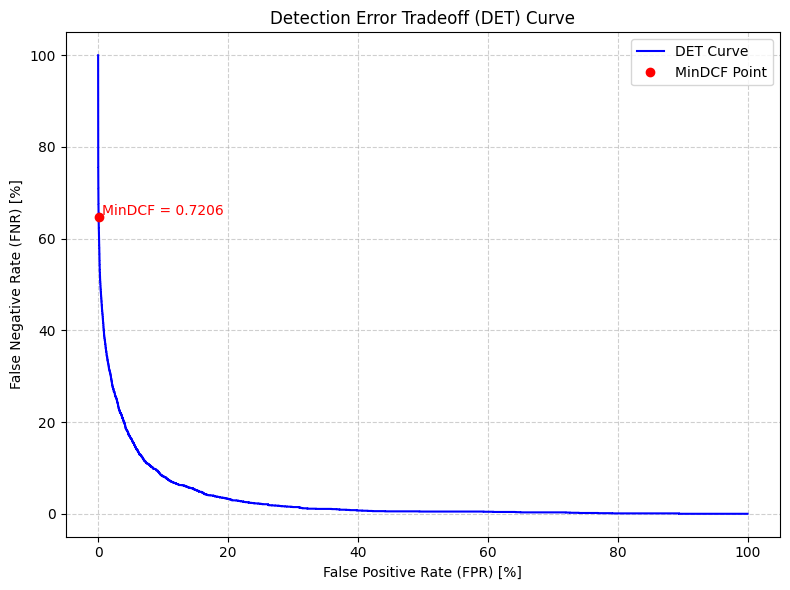

In [12]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

def load_embeddings_and_labels(pkl_path):
    with open(pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    embeddings = []
    labels = []

    for key, value in data.items():
        speaker_id = key.split('@')[0]
        labels.append(speaker_id)
        embeddings.append(np.array(value))

    return np.array(embeddings), np.array(labels)

def cosine_similarity(a, b):
    a_norm = a / np.linalg.norm(a)
    b_norm = b / np.linalg.norm(b)
    return np.dot(a_norm, b_norm)

def compute_scores_and_labels(embeddings, labels):
    scores = []
    targets = []

    num_embeddings = len(embeddings)
    for i in range(num_embeddings):
        for j in range(i + 1, num_embeddings):
            score = cosine_similarity(embeddings[i], embeddings[j])
            label = int(labels[i] == labels[j])
            scores.append(score)
            targets.append(label)
    
    return np.array(scores), np.array(targets)

def compute_min_dcf(scores, labels, p_target=0.01, c_miss=1, c_fa=1):
    fpr, tpr, thresholds = roc_curve(labels, scores, pos_label=1)
    fnr = 1 - tpr

    c_det = c_miss * fnr * p_target + c_fa * fpr * (1 - p_target)
    min_index = np.argmin(c_det)
    min_c_det = c_det[min_index]
    c_def = min(c_miss * p_target, c_fa * (1 - p_target))
    min_dcf = min_c_det / c_def
    return min_dcf, fpr, fnr, min_index

def plot_det_curve(fpr, fnr, min_index, min_dcf):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr * 100, fnr * 100, label='DET Curve', color='blue')

    # Mark MinDCF point
    plt.plot(fpr[min_index] * 100, fnr[min_index] * 100, 'ro', label='MinDCF Point')
    plt.text(fpr[min_index] * 100 + 0.5, fnr[min_index] * 100 + 0.5,
             f"MinDCF = {min_dcf:.4f}", color='red')

    plt.xlabel('False Positive Rate (FPR) [%]')
    plt.ylabel('False Negative Rate (FNR) [%]')
    plt.title('Detection Error Tradeoff (DET) Curve')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Main Execution ----
pkl_file = './speaker_embeddings_ECAPA.pkl'  # Replace with your actual file
embeddings, labels = load_embeddings_and_labels(pkl_file)
scores, target_labels = compute_scores_and_labels(embeddings, labels)
min_dcf, fpr, fnr, min_index = compute_min_dcf(scores, target_labels)

print(f"MinDCF: {min_dcf:.4f}")
plot_det_curve(fpr, fnr, min_index, min_dcf)

EER Plot

Calculating scores: 100%|██████████| 250000/250000 [00:04<00:00, 60894.63it/s]


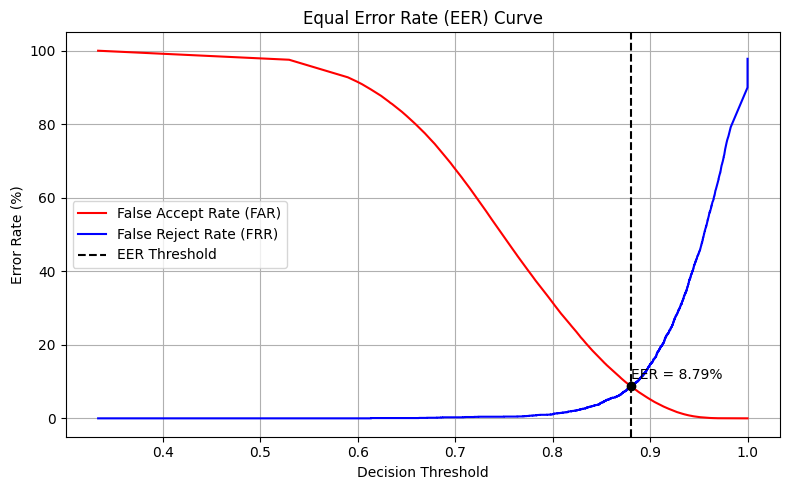


📊 Equal Error Rate (EER): 8.79%


In [11]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from tqdm import tqdm

# --------------------------
# Function to compute cosine similarity and collect scores
# --------------------------
def load_trial_and_scores(trial_file, emb_file):
    """Read trial file and calculate cosine similarity scores."""
    with open(emb_file, 'rb') as f:
        embeddings = pickle.load(f)

    y_true = []
    y_scores = []

    with open(trial_file, 'r') as f:
        for line in tqdm(f.readlines(), desc="Calculating scores"):
            line = line.strip()
            if not line:
                continue
            label, x_speaker, y_speaker = line.split()
            x_key = x_speaker.replace("/", "@")
            y_key = y_speaker.replace("/", "@")

            if x_key not in embeddings or y_key not in embeddings:
                print(f"Missing: {x_key} or {y_key}")
                continue

            x_vec = embeddings[x_key]
            y_vec = embeddings[y_key]

            score = np.dot(x_vec, y_vec) / (np.linalg.norm(x_vec) * np.linalg.norm(y_vec))
            score = (score + 1) / 2  # scale to [0, 1]

            y_scores.append(score)
            y_true.append(int(label))

    return np.array(y_true), np.array(y_scores)

# --------------------------
# Function to plot EER curve
# --------------------------
def plot_eer_curve(y_true, y_scores):
    """Plot EER curve with FAR and FRR."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    far = fpr
    frr = 1 - tpr

    eer_threshold = thresholds[np.nanargmin(np.abs(far - frr))]
    eer = far[np.nanargmin(np.abs(far - frr))]

    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, far * 100, label="False Accept Rate (FAR)", color="red")
    plt.plot(thresholds, frr * 100, label="False Reject Rate (FRR)", color="blue")
    plt.axvline(eer_threshold, color="black", linestyle="--", label="EER Threshold")
    plt.scatter([eer_threshold], [eer * 100], color="black", zorder=5)
    plt.text(eer_threshold, eer * 100 + 2, f"EER = {eer * 100:.2f}%", fontsize=10)

    plt.xlabel("Decision Threshold")
    plt.ylabel("Error Rate (%)")
    plt.title("Equal Error Rate (EER) Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return eer

# --------------------------
# 🔽 Replace these paths with your actual files
# --------------------------
trial_file = "./labels.txt"  # path to your trial file
embedding_pkl = "./speaker_embeddings_ECAPA.pkl"  # path to your pickle file containing embeddings

# --------------------------
# Run everything
# --------------------------
y_true, y_scores = load_trial_and_scores(trial_file, embedding_pkl)
eer = plot_eer_curve(y_true, y_scores)

print(f"\n📊 Equal Error Rate (EER): {eer * 100:.2f}%")
